### Storing image and labels

In [2]:
import os

In [3]:
os.getcwd() 

'c:\\Users\\anany\\Desktop\\project'

In [4]:
path_dataset=os.path.join('c:\\Users\\anany\\Desktop\\project','dataset') 

In [5]:
os.listdir(path_dataset)

['without_knife', 'with_knife']

In [6]:
Target_variable = os.listdir(path_dataset)

In [8]:
print(Target_variable)

['without_knife', 'with_knife']


In [6]:
data = [] 
labels = [] 

In [7]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [8]:
for target in Target_variable:
    
    path = os.path.join(path_dataset,target)   #We are inside the folder with_knife and without_knife
    for img in os.listdir(path):      # We will get a list of images in the current path
        img_path = os.path.join(path,img)
        image = load_img(img_path,target_size = (224,224))  # Loads image with a target size
        image = img_to_array(image)   # Converting image to an array.
        image = preprocess_input(image)   # When we use mobilenets we have to preprocess_input
        
        data.append(image)
        labels.append(target)
    

### Converting labels into binary

In [9]:
from sklearn.preprocessing import LabelBinarizer

In [10]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [11]:
from tensorflow.keras.utils import to_categorical

In [12]:
labels = to_categorical(labels)

### Converting data and labels into array

In [13]:
import numpy as np

In [14]:
data = np.array(data,dtype="float32")

In [15]:
labels = np.array(labels)

### Creating train test split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=.20,stratify = labels,random_state=42)

### Generating augmented data as dataset is small.

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

### Training

In [20]:
Learning_rate = 1e-3 

In [21]:
Epochs = 15

In [22]:
BS = 25

In [23]:
from tensorflow.keras.applications import MobileNetV2

In [24]:
from tensorflow.keras.layers import Input

In [25]:
base_model = MobileNetV2(weights = 'imagenet',include_top = False,input_tensor = Input(shape=(224,224,3)))

### Top Layer(Pooling+Flatten+Dense+Dropout+Dense)

In [26]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [27]:
headModel = base_model.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)   #remove less relevant features
headModel = Flatten(name="flatten")(headModel)              #converts input to 1D->required form of dense input
headModel = Dense(128, activation="relu")(headModel)        #relu: for non-linear
headModel = Dropout(0.5)(headModel)                         #model learning from same set, hence 50% neurons dropped per pass to prevent overfitting
headModel = Dense(2, activation="softmax")(headModel)       #softmax for O/P layer: probability based activation function, between 0 & 1

In [28]:
from tensorflow.keras.models import Model

In [29]:
model = Model(inputs=base_model.input, outputs=headModel)

In [30]:
for layer in base_model.layers:
	layer.trainable = False

### Compiling

In [31]:
from tensorflow.keras.optimizers import Adam

In [32]:
optim = Adam(lr=Learning_rate, decay=Learning_rate/ Epochs)
model.compile(loss="binary_crossentropy", optimizer=optim,metrics=["accuracy"])
#optimiser: decides how weights will be updated in back propagation

c:\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [33]:
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test,y_test),
    validation_steps=len(X_test) // BS,
    epochs=Epochs)

Epoch 1/15
21/21 [==============================] - 36s 1s/step - loss: 0.3068 - accuracy: 0.8695 - val_loss: 0.1416 - val_accuracy: 0.9343
Epoch 2/15
21/21 [==============================] - 29s 1s/step - loss: 0.1088 - accuracy: 0.9655 - val_loss: 0.0586 - val_accuracy: 0.9708
Epoch 3/15
21/21 [==============================] - 27s 1s/step - loss: 0.0720 - accuracy: 0.9789 - val_loss: 0.0277 - val_accuracy: 0.9927
Epoch 4/15
21/21 [==============================] - 28s 1s/step - loss: 0.0456 - accuracy: 0.9942 - val_loss: 0.0183 - val_accuracy: 0.9927
Epoch 5/15
21/21 [==============================] - 25s 1s/step - loss: 0.0345 - accuracy: 0.9904 - val_loss: 0.0128 - val_accuracy: 0.9927
Epoch 6/15
21/21 [==============================] - 27s 1s/step - loss: 0.0431 - accuracy: 0.9808 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 7/15
21/21 [==============================] - 27s 1s/step - loss: 0.0277 - accuracy: 0.9923 - val_loss: 0.0089 - val_accuracy: 0.9927
Epoch 8/15
21/21 [==

### Predictions

In [34]:
predictions = model.predict(X_test, batch_size=BS)

6/6 [==============================] - 6s 869ms/step


In [35]:
predictions = np.argmax(predictions, axis=1)

In [36]:
from sklearn.metrics import classification_report

In [37]:
X_test[1].shape

(224, 224, 3)

In [38]:
print(classification_report(y_test.argmax(axis=1), predictions,target_names=lb.classes_))

               precision    recall  f1-score   support

   with_knife       0.99      1.00      1.00       117
without_knife       1.00      0.95      0.97        20

     accuracy                           0.99       137
    macro avg       1.00      0.97      0.99       137
 weighted avg       0.99      0.99      0.99       137



### Saving the model

In [39]:
model.save("knife_detector.model5", save_format="h5")

In [40]:
import matplotlib.pyplot as plt

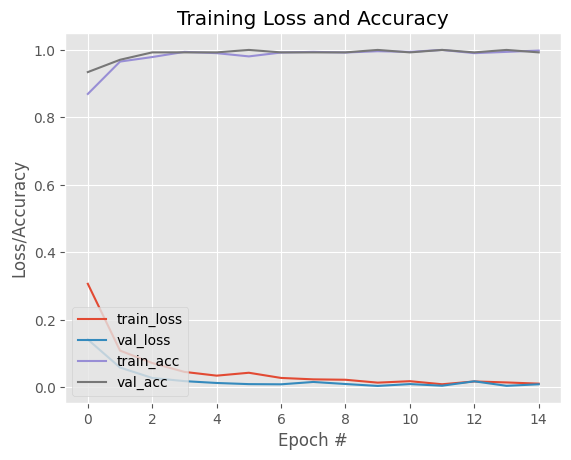

In [41]:
N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.savefig('plot.png')